In [1]:
# Global imports
import os
import importlib
import tensorflow as tf
from datetime import datetime

%load_ext autoreload
%autoreload 2

In [2]:
# The Colab cell. If True, will set up the file system and git
COLAB = False
BRANCH = 'main'
USERNAME = 'ben'
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/Shareddrives/ML_Road_Segmentation/CS-433-project-{}/project_road_segmentation'.format(USERNAME)
    os.chdir(drive_path)
    from helpers.colab import pull
    BRANCH_NAME = BRANCH
    mount_and_pull(BRANCH_NAME, drive, os)

In [5]:
# Scripts imports
# from helpers.x import y
from helpers.constants import *
from helpers.machine_learning import get_train_test, compute_entire_images_metrics
from helpers.loss_functions import dice_coefficient, create_loss_function
from helpers.prediction_checking import visualize_random_predictions
from helpers.submission import predict_submissions

In [6]:
# Utilitary constants
RESTORE_MODEL = False  # Restore existing model instead of training a new one
SAVE_MODEL = False  # Save the model as a zip file (only works on AICrowd)
GENERATE_PREDICTION = True  # Generate a CSV to submit on AICrowd

MODEL_NAME = 'cnn_patch_prediction'  # cnn_patch_prediction or unet
PATCH_PREDICTION = MODEL_NAME == 'cnn_patch_prediction' # Only for the non-unet model, which predicts patches
SAVE_DIR = MODELS_SAVE_DIR + MODEL_NAME + '/'  # Directory in which to save the model
RELOAD_DIR = MODELS_SAVE_DIR + 'final_model/'  # Directory from which to reload the model

# Model constants
NUM_EPOCHS = 250
ALPHA = 0.5
GAMMA = 1.0
DATA_AUGMENTATION = True
TRANSFORMATIONS = ['mix', 'rotations']

# Importing the model
mod = importlib.import_module('models.' + MODEL_NAME)
model_function = getattr(mod, MODEL_NAME)

Loading data/train/generated/mix/groundtruth/: 100%|████████████████████████████████| 100/100 [00:00<00:00, 126.90it/s]


Training features shape :  (200, 400, 400, 3)
Training labels shape :  (200, 400, 400)
(160, 25, 25)
(40, 25, 25)


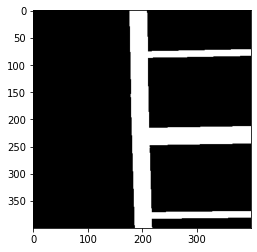

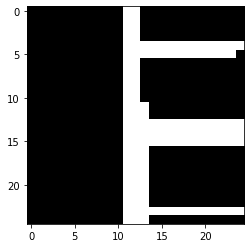

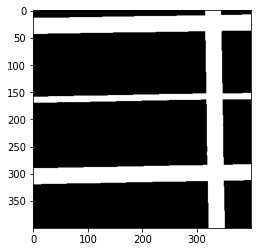

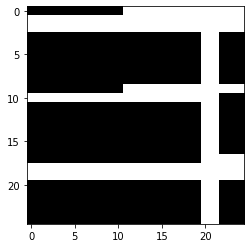

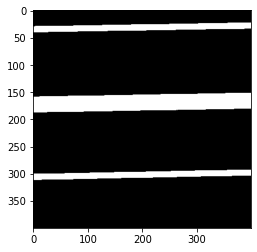

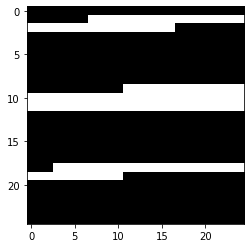

In [9]:
# Loading the data
X_train, y_train, X_test, y_test = get_train_test(data_augmentation=DATA_AUGMENTATION, transformations=TRANSFORMATIONS)

if PATCH_PREDICTION:
    from helpers.patch_labeling import *
    y_train = groundtruth_to_labeled_patches(y_train)
    y_test = groundtruth_to_labeled_patches(y_test)

In [10]:
# Reloading or training the model
loss_function = create_loss_function(ALPHA, GAMMA)

if RESTORE_MODEL:
    model = tf.keras.models.load_model(RELOAD_DIR, custom_objects={'focal_tversky_loss': loss_function, 'dice_coef': dice_coefficient})
else:  
    metrics=[tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             dice_coefficient]
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5)]
    model = model_function()
    model.compile(optimizer='adam',
                  loss=loss_function,
                  metrics=metrics)
    history = model.fit(X_train, 
                        y_train, 
                        epochs=NUM_EPOCHS,
                        validation_split=0.2,
                        callbacks=callbacks)

Epoch 1/250
4/4 [==============================] - ETA: 0s - loss: 0.6338 - precision: 0.2468 - recall: 0.7584 - dice_coefficient: 0.3662 

KeyboardInterrupt: 

In [36]:
# Saving the trained model
if SAVE_MODEL:
    now = datetime.now().strftime("%m-%d-%Y_%H-%M-%S") + '/'
    model.save(SAVE_DIR + now)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/unet/12-15-2020_23-19-50/assets


In [13]:
# Predicting on train and test and computing performance
train_predictions = model.predict(X_train).squeeze()
test_predictions = model.predict(X_test).squeeze()
metrics = compute_entire_images_metrics(y_test, test_predictions)

if PATCH_PREDICTION:
    train_predictions = resize_images(train_predictions, TRAINING_IMG_SIZE)
    test_predictions = resize_images(test_predictions, TRAINING_IMG_SIZE)
    
metrics

,f1,acc,precision,recall
metrics,0.401279,0.251,0.251,1.0


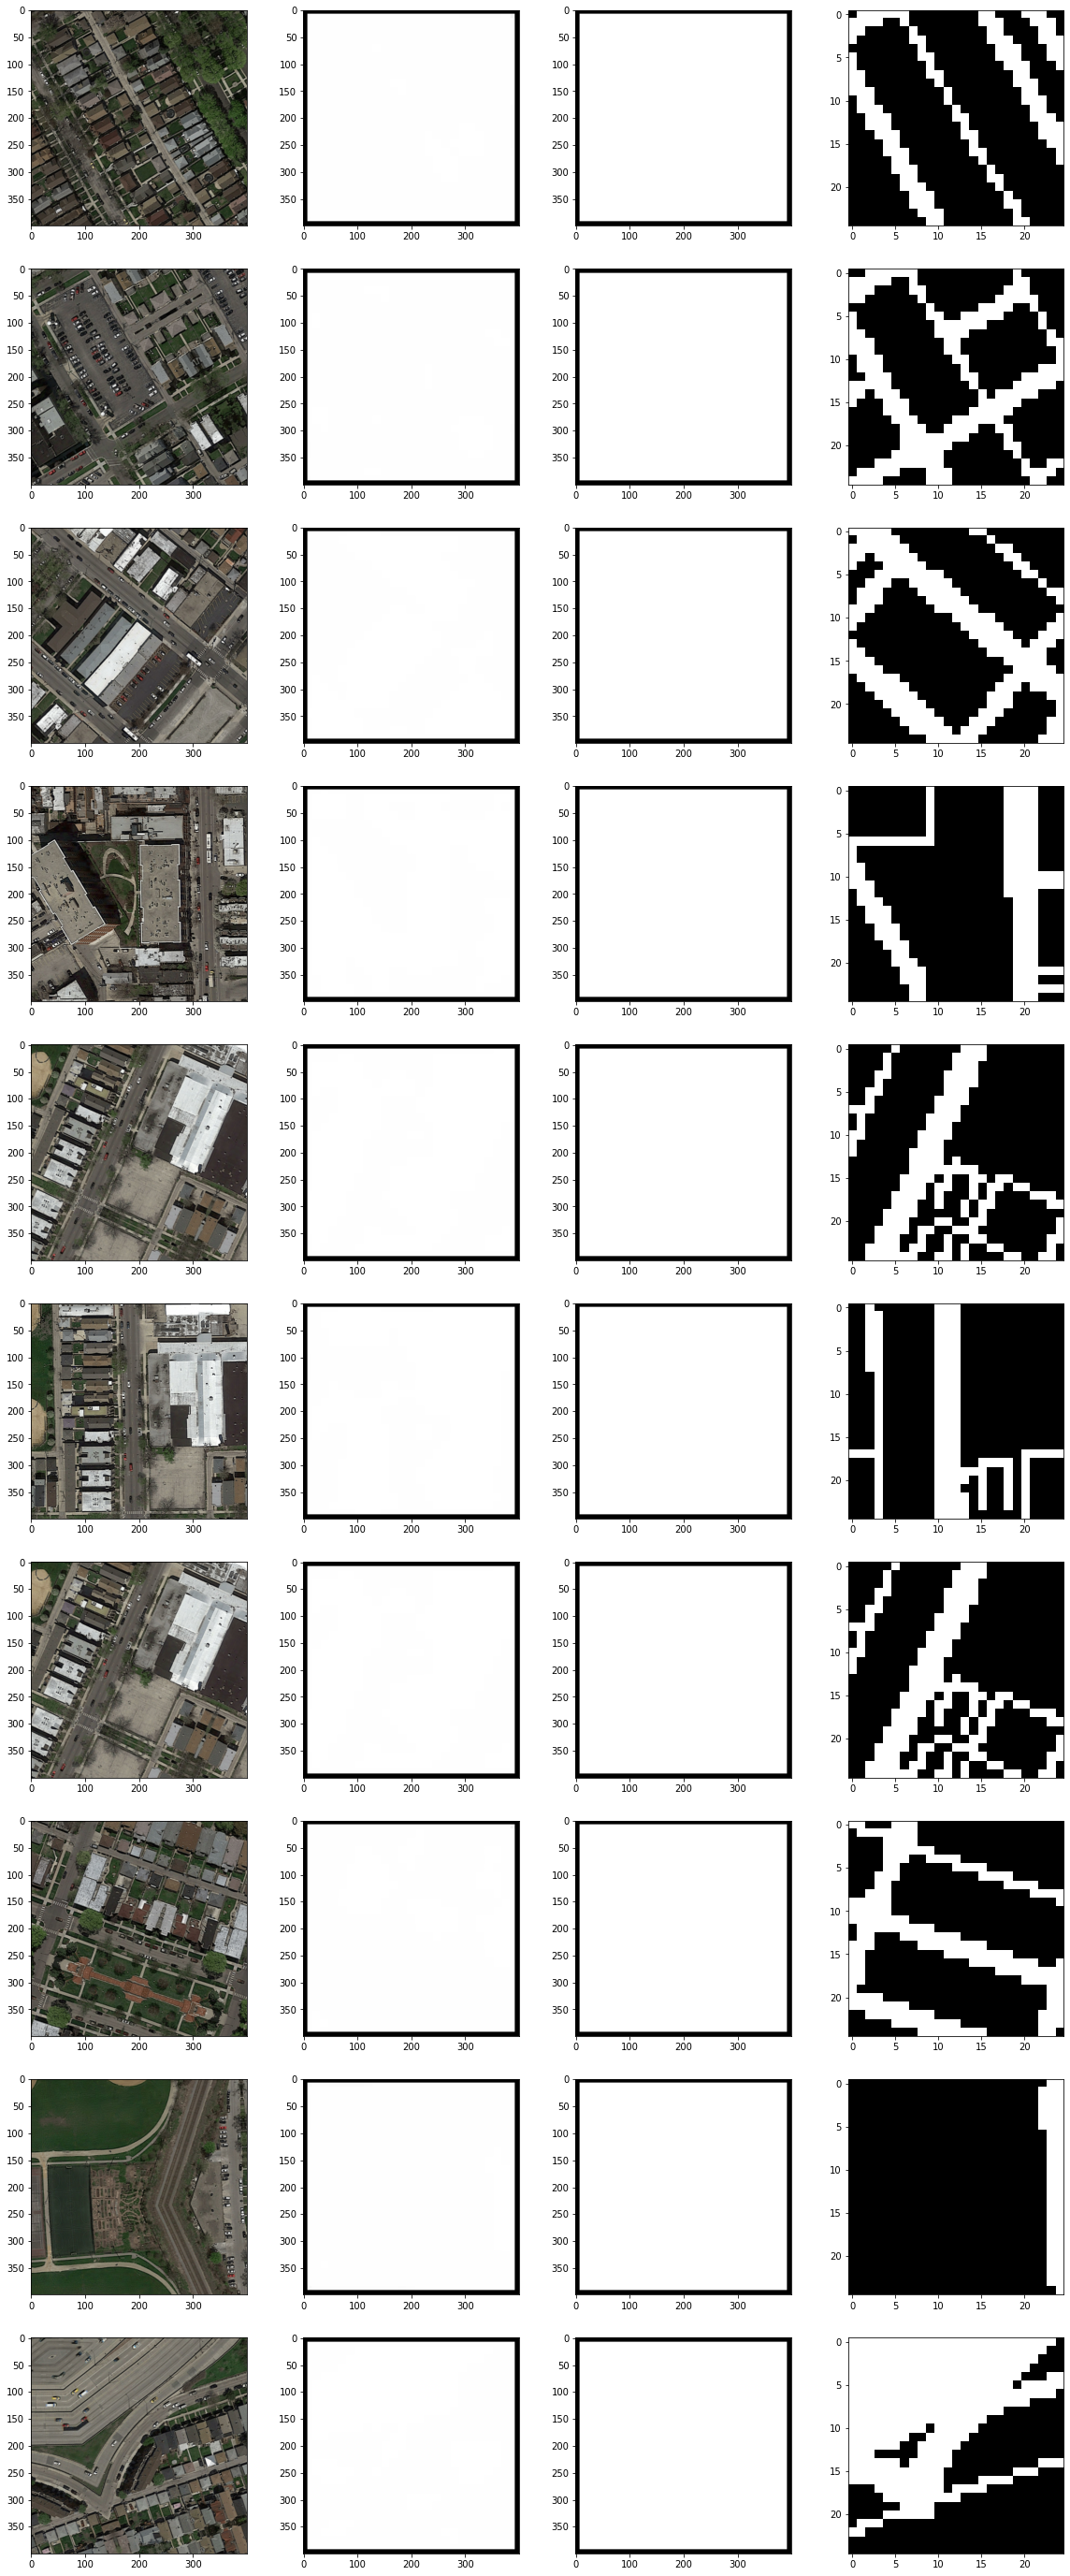

In [14]:
visualize_random_predictions(X_train, y_train, train_predictions, size=10)

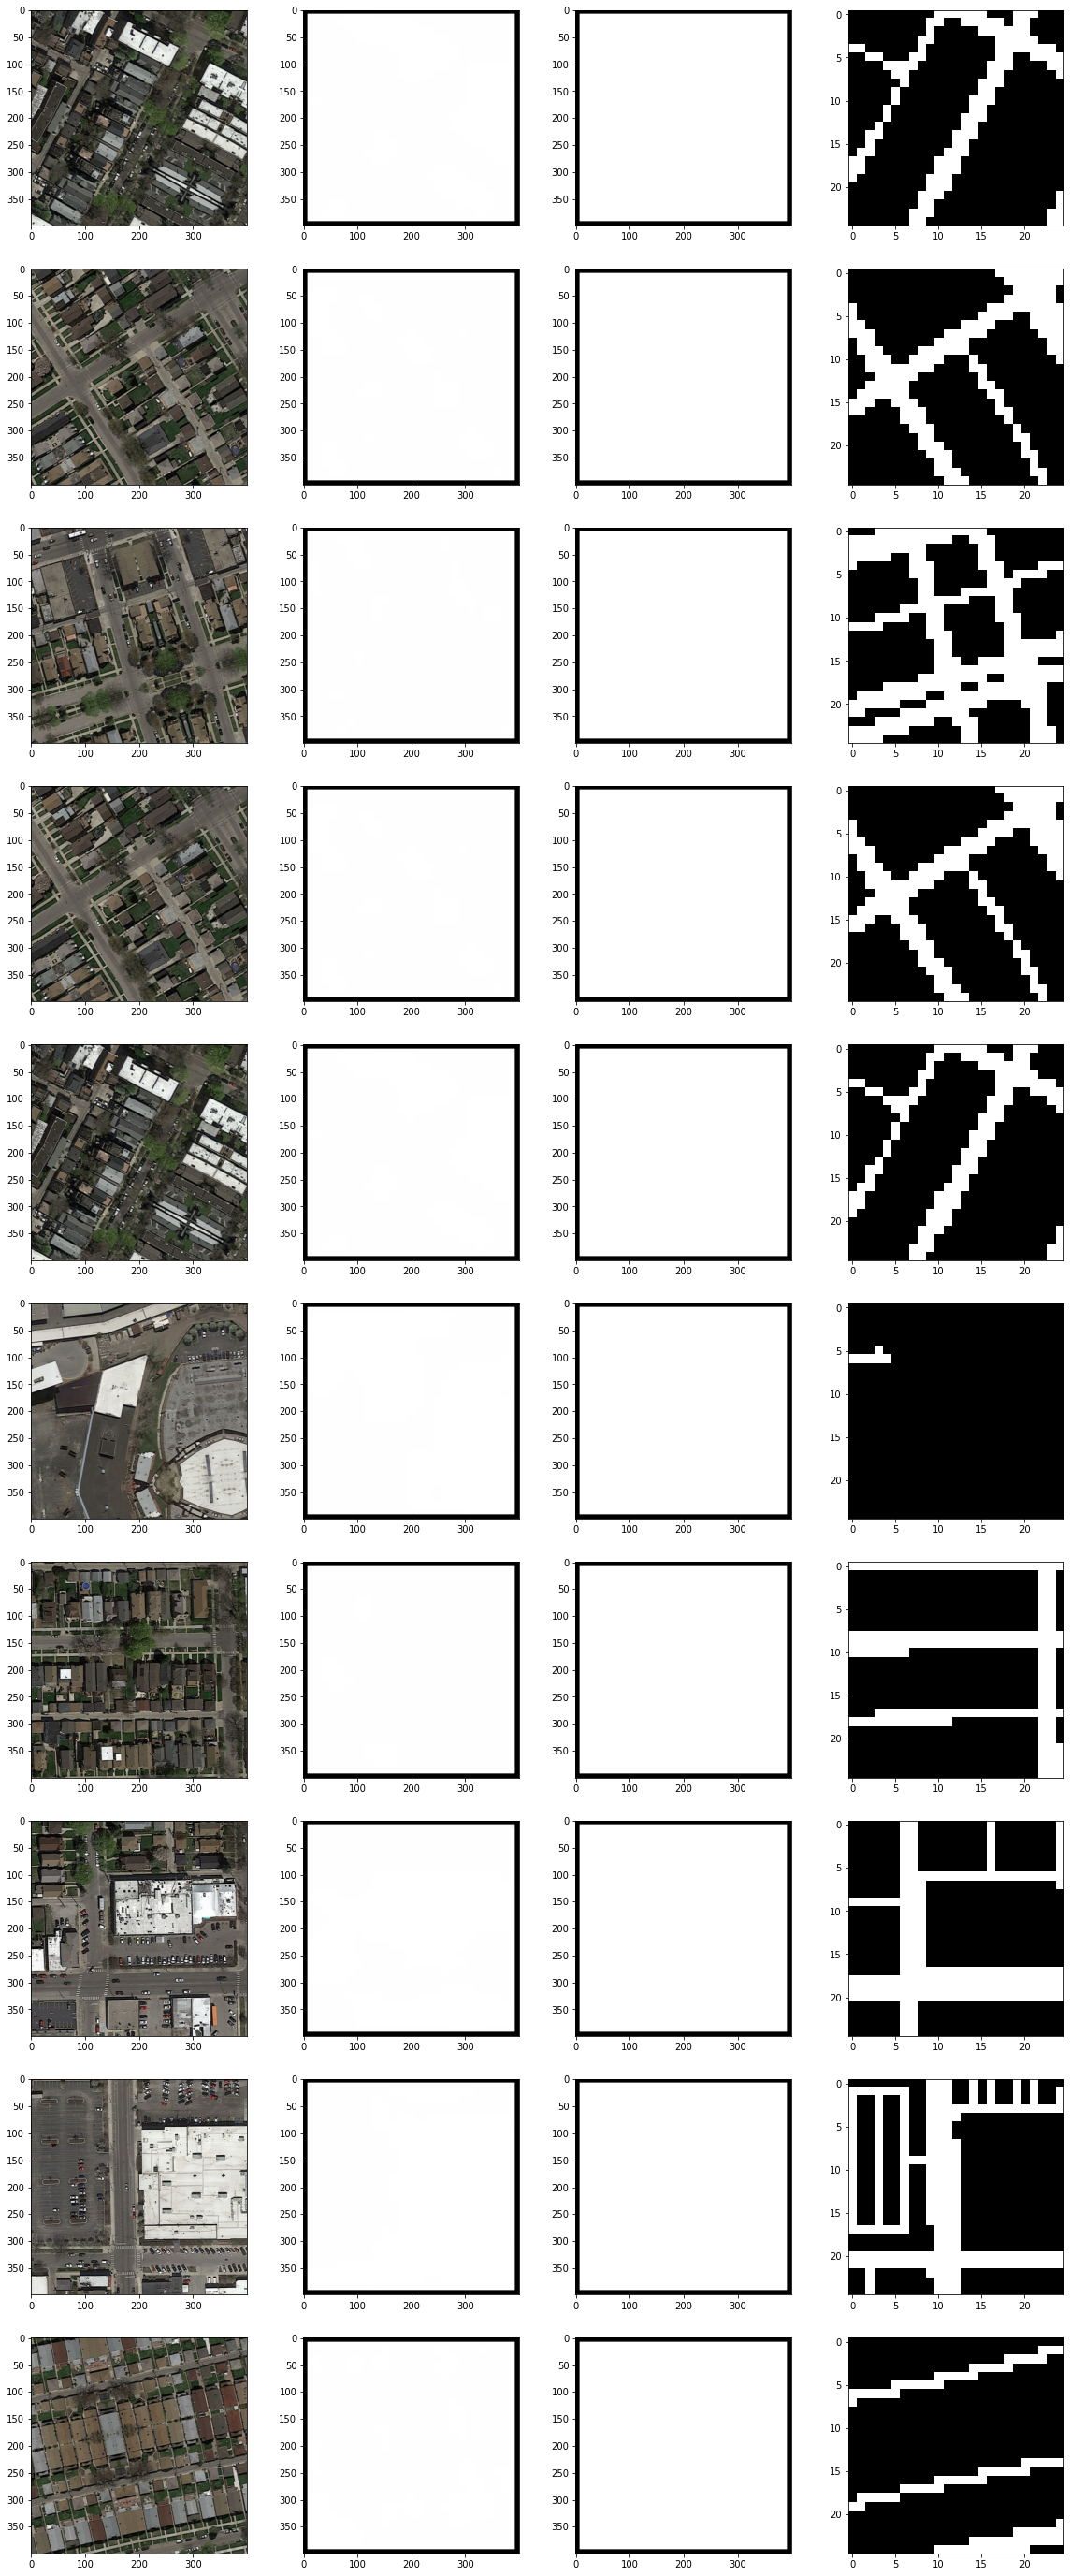

In [15]:
visualize_random_predictions(X_test, y_test, test_predictions, size=10)

In [ ]:
predict_submissions(model, patches_predicted=PATCH_PREDICTION)

Loading data/test/original/: 100%|█████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.86it/s]


Predicting test images...


In [12]:
if COLAB:
    from helpers.colab import download_model
    from google.colab import files
    download_model(MODEL_NAME, SAVE_DIR, files)